# Tutorial 2: data integration for mouse thymus Stereo-CITE-seq

In this tutorial, we demonstrate how to apply SpatialGlue to integrate Stereo-CITE-seq (Liao et al.) data to obtain fine-grained clusters. Stereo-CITE-seq co-detects mRNAs and proteins in immune organs. As a example, we analyse a mouse thymus dataset. We collected the data from BGI. According to marker genes and proteins, we manually annotated the tissue to 8 cell types as shown below.

Before running the model, please download the input data via https://drive.google.com/drive/folders/17hDLGDENIds1_I8WlQ_c8tcxkjLIuVFV.

## Loading package

In [93]:
import os
import torch
import pandas as pd
import scanpy as sc

In [94]:
from SpatialGlue import SpatialGlue

In [95]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'

# fix random seed
from SpatialGlue.preprocess import fix_seed
random_seed=2022
fix_seed(random_seed)

In [96]:
# the number of clusters
n_clusters = 8

## Loading data

In [97]:
# read data
file_fold = '/home/yahui/anaconda3/work/SpatialGlue_omics/data/Thymus/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_ADT.h5ad') 

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

In [98]:
adata_omics1

AnnData object with n_obs × n_vars = 4697 × 23622
    obs: 'orig.ident', 'x', 'y'
    obsm: 'spatial'

In [99]:
adata_omics2

AnnData object with n_obs × n_vars = 4697 × 51
    obs: 'orig.ident', 'x', 'y'
    obsm: 'spatial'

# Pre-processing data
After reading data of two omics modalities, SpatialGlue pre-processes the data as inputs of the model, including expression feature pre-processing and neighbor graph construction. More details can be found in the paper. (https://www.biorxiv.org/content/10.1101/2023.04.26.538404v2) 

The pre-processed features will be saved in adata_omics1.obsm['feat'] and adata_omics2.obsm['feat'] for modalities 1 and 2 respectively. 

In [100]:
from SpatialGlue.preprocess import preprocessing
data = preprocessing(adata_omics1, adata_omics2, datatype='Stereo-CITE-seq')

/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/scanpy/preprocessing/_pca.py:229: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.obsm['X_pca'] = X_pca


In [101]:
adata_omics1 = data['adata_omics1']
adata_omics2 = data['adata_omics2']

# Raw expression data analysis

In [102]:
from SpatialGlue.utils import clustering 

# clustering
clustering(adata_omics1, key='feat', add_key='RNA', n_clusters=n_clusters)
clustering(adata_omics2, key='feat', add_key='protein', n_clusters=n_clusters)

fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


In [103]:
import numpy as np
# flip tissue image 
adata_omics1.obsm['spatial'][:,1] = -1*adata_omics1.obsm['spatial'][:,1]
adata_omics2.obsm['spatial'][:,1] = -1*adata_omics2.obsm['spatial'][:,1]

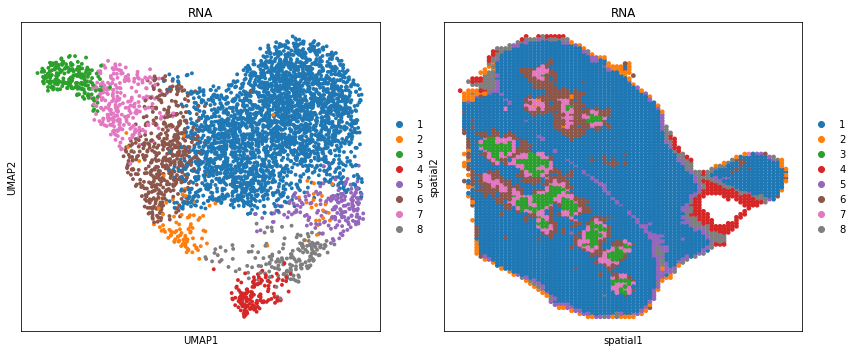

In [104]:
# visualization
import matplotlib.pyplot as plt

# mRNA
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(adata_omics1, use_rep='feat', n_neighbors=10)
sc.tl.umap(adata_omics1)

sc.pl.umap(adata_omics1, color='RNA', ax=ax_list[0], title='RNA', s=60, show=False)
sc.pl.embedding(adata_omics1, basis='spatial', color='RNA', ax=ax_list[1], title='RNA', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

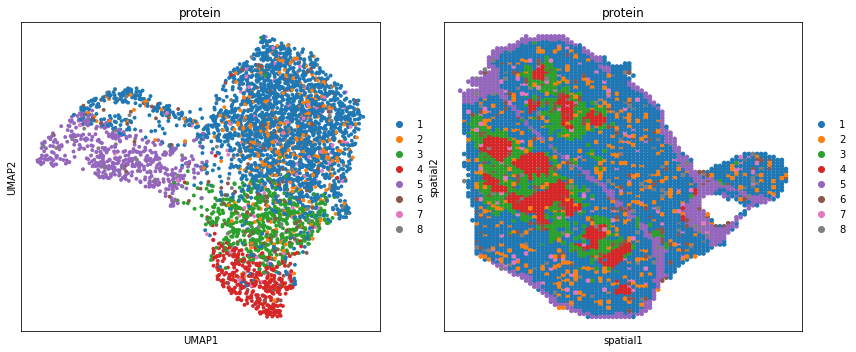

In [105]:
# protein
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(adata_omics2, use_rep='feat', n_neighbors=10)
sc.tl.umap(adata_omics2)

sc.pl.umap(adata_omics2, color='protein', ax=ax_list[0], title='protein', s=60, show=False)
sc.pl.embedding(adata_omics2, basis='spatial', color='protein', ax=ax_list[1], title='protein', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

## Training the model

SpatialGlue model aims to learn an integrated latent representation by adaptively integrating expression profiles of different omics modalities in a spatially aware manner. 

After model training, SpatialGlue returns 'output' file. The 'output' file include multiple output results. Let's go through each of the results in more detail:

1. Latent Representations:

* 'emb_latent_omics1': This represents the modality-specific latent representation for the first omics modality.

* 'emb_latent_omics2': Similarly, this represents the modality-specific latent representation for the second omics modality.

* 'emb_combined': This represents the integrated latent representation that combines expression features and spatial information from both omics modalities. It provides a joint representation that captures the cross-omics information in a spatially aware manner.

   The integrated representation can be used as feature vectors for downstream analysis tasks such as clustering, visualization, or identifying differentially expressed genes (DEGs).

2. Attention Weight Values:

* 'alpha_omics1': This attention weight value represents the within-modality attention weight for the first omics modality. It indicates the importance of each neighbor graph within the same modality.

* 'alpha_omics2': Similarly, this attention weight value represents the within-modality attention weight for the second omics modality.

* 'alpha': This attention weight value represents the between-modality attention weight. It indicates the importance of each modalities to each cell type.

   These attention weight values provide insights into the importance of the neighborhood graph or modality for each cell type. They can help identify which modalities or neighbor graphs are more crucial for specific cell types, guiding further analysis and interpretation of the results.

In [106]:
# define model
model = SpatialGlue.SpatialGlue(data, datatype='Stereo-CITE-seq', device=device)

# train model
output = model.train()

  0%|                                                                                   | 0/1500 [00:00<?, ?it/s]/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/SpatialGlue/model.py:167: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|████████████████████████████████████████████████████████████████████████| 1500/1500 [00:38<00:00, 38.54it/s]

Model training finished!



In [107]:
output.keys()

dict_keys(['emb_latent_omics1', 'emb_latent_omics2', 'emb_latent_combined', 'alpha_omics1', 'alpha_omics2', 'alpha'])

In [108]:
adata_combined = adata_omics1.copy()
adata_combined.obsm['emb_latent_omics1'] = output['emb_latent_omics1']
adata_combined.obsm['emb_latent_omics2'] = output['emb_latent_omics2']
adata_combined.obsm['emb_latent_combined'] = output['emb_latent_combined']

## Cross-omics integrative analysis

After integration, we perform clustering analysis using the integrated representation. Here we provid three optional kinds of tools for spaital clustering, including mclust, leiden, and louvain. In our experiment, we find mclust performs better than leiden and louvain on spatial data in most cases. Therefore, we recommend using mclust.

In [109]:
# we use mcluster as clustering tool by default.
tool = 'mclust' # mclust, leiden, and louvain

# performing PCA
adata_combined.obsm['emb_combined_pca'] = sc.tl.pca(adata_combined.obsm['emb_latent_combined'], n_comps=20)

# clustering
if tool == 'mclust':
   clustering(adata_combined, key='emb_combined_pca', add_key='SpatialGlue', n_clusters=n_clusters, method=tool) 
elif tool in ['leiden', 'louvain']:
   clustering(adata_combined, key='emb_combined_pca', add_key='SpatialGlue', n_clusters=n_clusters, method=tool, start=0.1, end=2.0, increment=0.01) 

fitting ...
  |======================================================================| 100%


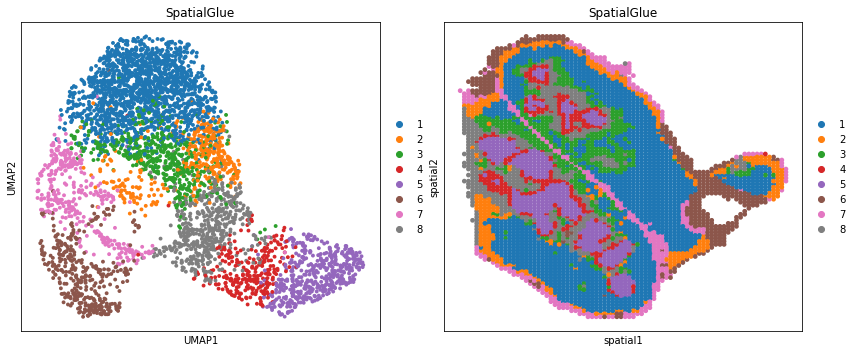

In [110]:
# visualization
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(adata_combined, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(adata_combined)

sc.pl.umap(adata_combined, color='SpatialGlue', ax=ax_list[0], title='SpatialGlue', s=60, show=False)
sc.pl.embedding(adata_combined, basis='spatial', color='SpatialGlue', ax=ax_list[1], title='SpatialGlue', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

In [113]:
# annotation
adata_combined.obs['SpatialGlue'].cat.rename_categories({1: 'Outer cortex region 3(DN T,DP T,cTEC)',
                                                   2: 'Subcapsular zone(DN T)',
                                                   3: 'Middle cortex region 2(DN T,DP T,cTEC)',
                                                   4: 'Corticomedullary Junction(CMJ)',
                                                   5: 'Medulla(SP T,mTEC,DC)',
                                                   6: 'Connective tissue capsule(fibroblast,RBC,myeloid)',
                                                   7: 'Connective tissue capsule(fibroblast)', 
                                                   8: 'Inner cortex region 1(DN T,DP T,cTEC)'
                                                   }, inplace=True)

/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [118]:
list_ = ['Inner cortex region 1(DN T,DP T,cTEC)', 'Corticomedullary Junction(CMJ)',  'Middle cortex region 2(DN T,DP T,cTEC)', 
         'Subcapsular zone(DN T)', 'Outer cortex region 3(DN T,DP T,cTEC)',  'Connective tissue capsule(fibroblast,RBC,myeloid)',
         'Medulla(SP T,mTEC,DC)', 'Connective tissue capsule(fibroblast)',
           ]
adata_combined.obs['SpatialGlue']  = pd.Categorical(adata_combined.obs['SpatialGlue'], 
                      categories=list_,
                      ordered=True)

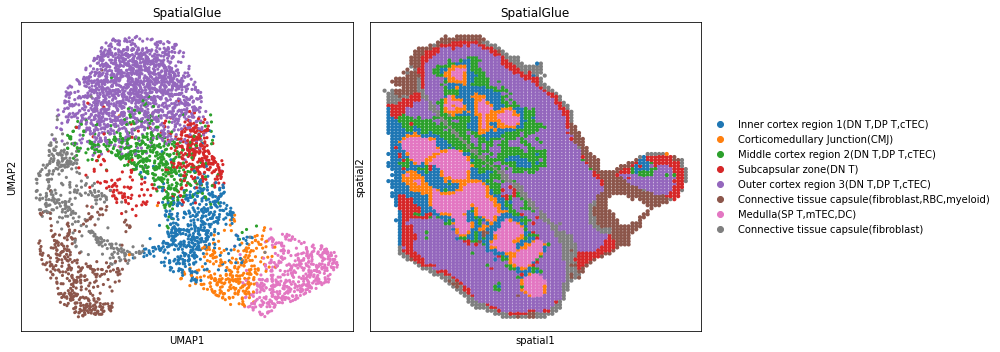

In [119]:
# plotting with annotation
fig, ax_list = plt.subplots(1, 2, figsize=(14, 5))
sc.pp.neighbors(adata_combined, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(adata_combined)

sc.pl.umap(adata_combined, color='SpatialGlue', ax=ax_list[0], title='SpatialGlue', s=40, show=False)
sc.pl.embedding(adata_combined, basis='spatial', color='SpatialGlue', ax=ax_list[1], title='SpatialGlue', s=70, show=False)

ax_list[0].get_legend().remove()

plt.tight_layout(w_pad=0.3)
plt.show()

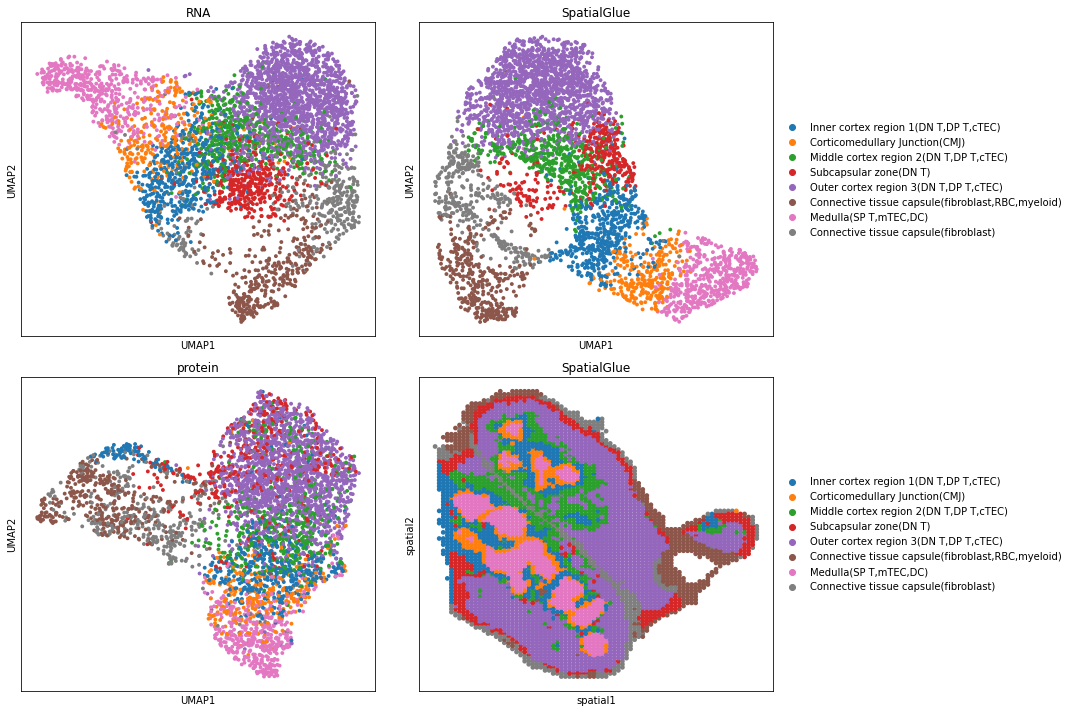

In [121]:
# joint plotting of raw and integrated data colored by SpatialGlue's lable
fig, ax_list = plt.subplots(2, 2, figsize=(15, 10))

adata_omics1.obs['SpatialGlue'] = adata_combined.obs['SpatialGlue'].copy()
adata_omics2.obs['SpatialGlue'] = adata_combined.obs['SpatialGlue'].copy()

sc.pl.umap(adata_omics1, color='SpatialGlue', ax=ax_list[0, 0], title='RNA', s=60, show=False)
sc.pl.umap(adata_omics2, color='SpatialGlue', ax=ax_list[1, 0], title='protein', s=60, show=False)

sc.pl.umap(adata_combined, color='SpatialGlue', ax=ax_list[0, 1], title='SpatialGlue', s=60, show=False)
sc.pl.embedding(adata_combined, basis='spatial', color='SpatialGlue', ax=ax_list[1, 1], title='SpatialGlue', s=90, show=False)

ax_list[0, 0].get_legend().remove()
ax_list[1, 0].get_legend().remove()

plt.tight_layout(w_pad=3)
plt.show()

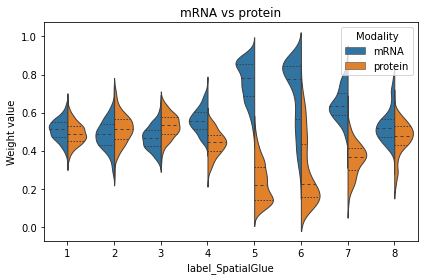

In [112]:
# plotting modality weight values
# To visualize the weight values of different modalities, we provide 'plot_weight_value' function. 
from SpatialGlue.utils import plot_weight_value
plot_weight_value(output['alpha'], adata_combined.obs['SpatialGlue'].values)